# Unsupervised to Supervised Learning: Self Organising Map (SOM) with  Artifical Neutral Networks (ANN) 
## Objectives: 
Using Self-Organising Maps (SOM) and Artifical Neutral Networks (ANN) to: 
* Learn and train based on the matrix of features for features detection using an unsuperversied learning approach (SOM)
* Visualise the analysis result from high dimensional dataset into low dimensional 2-D Mapping, called SOM. 
* Learn a dataset without supervision (a target vector). A SOM consists of a grid of nodes or units to which the input data are presented. Every node is connected to the input, and there is no connection between the nodes. 
* Preserve topology and keep the neighborhood relations in its mapping presentation 
* Apply stochastic gradient descent to minimise the lose function
* Complete backpropagation to adjusts the weights 
* Complete k-cross validation

## Steps: 
1) Visualise the dataset, analysis by pivoting features, categorical encoding and feature scaling

2) Train the Self Organising Map for the dataset 

3) Visualise the results, overlap customers who have and have not defaulted on their credit cards

4) Identify customer groups (clusters) which have a high risk of defaulting 

2) Initialise ANN
    
3) Add first layer with 24 input nodes, set activation function 
  
5) Add output layer in the form of perceptron and a sigmoid function

6) Apply stochastic gradient descent to achieve a set of optimal weights

7) Evaluate the model, visualise the analysis results

Scenario: To build a predictive model for a bank to rank customers who are likely to default on their credit card payments. Rank the highest risk defaulters at the top. 

### Dataset: 

Credit_card.csv: info Customers bank account

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Matrix of Features: 30,000 x 25

In [1]:
# Importing the libraries
import numpy as np
np.random.seed(123)  # for reproducible results
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
# Importing the dataset
df = pd.read_csv('credit_card.csv')

In [3]:
#INSPECTION
df.head() 

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,defaulted
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.columns.values

array(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'defaulted'], dtype=object)

## Check if there are any NAN in each column, and in what % 
* Rank the column with worst sparsity at the top 
* There is no misssing data in this dataset

In [5]:
missing_data = df.isnull().sum().sort_values(ascending = False)
sparsity = missing_data/missing_data.count()*100
missing_data = pd.concat([missing_data, round(sparsity).sort_values(ascending = False)], 
                          axis=1, keys=['Missing Total', 'Sparsity %'])
missing_data.head(5)

,Missing Total,Sparsity %
AGE,0,0.0
BILL_AMT1,0,0.0
BILL_AMT2,0,0.0
BILL_AMT3,0,0.0
BILL_AMT4,0,0.0


## Check number of customers defaulted

In [6]:
defaulted = df['defaulted'].value_counts()
print('\n Number of customers defaulted: {} out of {}'.format(defaulted[1], len(df)))


 Number of customers defaulted: 6636 out of 30000


## Initial analysis by pivoting features
* Inspecting correlation between customers defaulted, by SEX, EDUCATION, AGE 
* SEX: (1) Male and (2) Female correlated similarly.  
* EDUCATION: (3) High School educated customers and (2) University educated customers ranked highest 

In [7]:
df[['SEX', 'defaulted']].groupby(['SEX'], as_index=False).mean().sort_values(by='defaulted', ascending=False)

,SEX,defaulted
0,1,0.241672
1,2,0.207763


In [8]:
df[['EDUCATION', 'defaulted']].groupby(['EDUCATION'], as_index=False).mean().sort_values(by='defaulted', ascending=False)

,EDUCATION,defaulted
3,3,0.251576
2,2,0.237349
1,1,0.192348
6,6,0.156863
5,5,0.064286
4,4,0.056911
0,0,0.000000


In [9]:
age_groups = df[['AGE', 'defaulted']].groupby(['AGE'], as_index=False).mean().sort_values(by='defaulted', ascending=False)
age_groups.head(10)

,AGE,defaulted
52,73,0.750000
40,61,0.375000
39,60,0.343284
54,75,0.333333
51,72,0.333333
46,67,0.312500
1,22,0.301786
43,64,0.290323
45,66,0.280000
25,46,0.275439


In [10]:
age_groups.tail(10)

,AGE,defaulted
9,30,0.196416
8,29,0.195016
11,32,0.194301
10,31,0.188168
24,45,0.188006
12,33,0.187609
41,62,0.159091
50,71,0.000000
53,74,0.000000
55,79,0.000000


## Plot the correlation between age and defaulted
* Age between 20 to 40 have a relative higher tendenacy to be defaulted than other age group 
* Out of the segment about, female appear to have a marginal tendenacy to be defaulted than male segment 

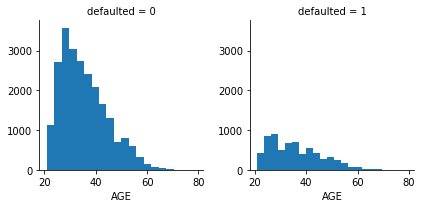

In [11]:
g = sns.FacetGrid(df, col='defaulted')
g.map(plt.hist, 'AGE', bins=20) 

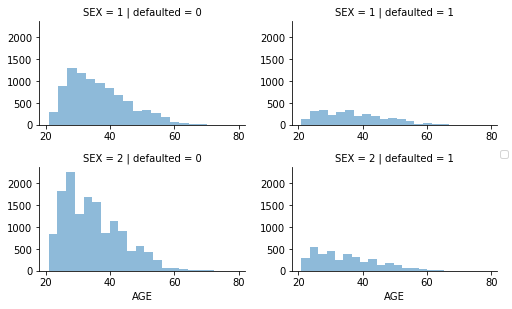

In [12]:
grid = sns.FacetGrid(df, col='defaulted', row='SEX', size=2.2, aspect=1.6)
grid.map(plt.hist, 'AGE', alpha=.5, bins=20)
grid.add_legend()

## Data Preprocessing - Feature Scaling (Normalisation)

In [13]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [14]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X.astype('float64'))

## Training the Self Organising Map (SOM)

In [15]:
from minisom import MiniSom
som = MiniSom(x = 20, y = 20, input_len = 24, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

## Visualising the results

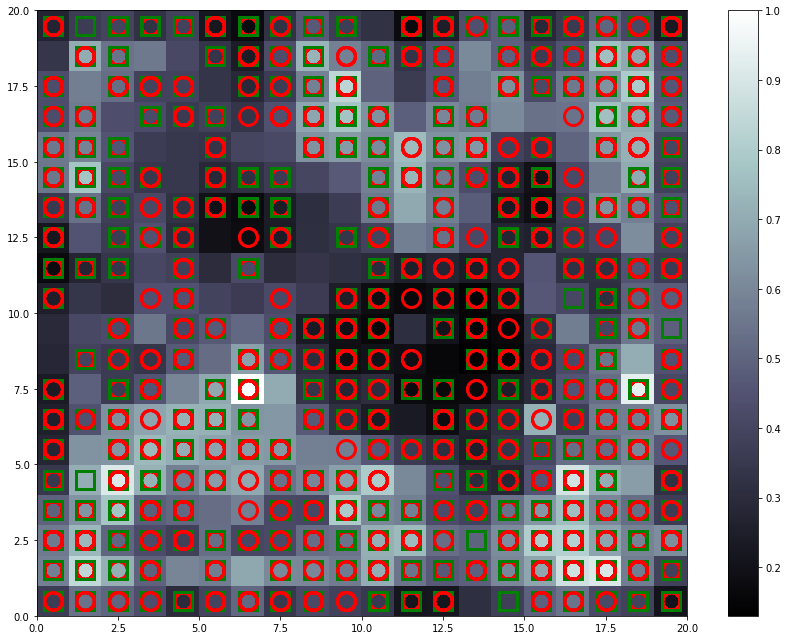

In [16]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
#Returns the distance map (matrix) of the weights (Mean Inter-neurons Distances (MID))
#Each cell is the normalised (0 to 1) sum of the distances between a neuron (winning node) and its neighbours.
plt.figure(figsize=(12,9))
pcolor(som.distance_map().T) 
colorbar() #legend (1 indicates highest MID - outliers)
markers = ['o', 's'] #circles(customer defaulted payment), squares(customer not defaulted payment)
colors = ['r', 'g'] #rad (customer defaulted payment), green(customer not defaulted payment)

for i, x in enumerate(X): #i (loops through y[index], x (loops through customers denoted as X))
    w = som.winner(x)
    plot(w[0] + 0.5, #co-ordinate along x-axis
         w[1] + 0.5, #co-ordinate along y-axis
         markers[y[i]], #y[i] == 1 (customer defaulted payment), y[i] == 0 (customer not defaulted payment)
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 18,
         markeredgewidth = 3)

plt.tight_layout()
plt.show()

## Finding the credit card defaulters
* get the mappings from winning nodes to the corresponding customers
* mappings is a dictionary with key = (x,y) co-ordinates of the SOM
* each key is referring to the group of customers associated with that winning node

In [17]:
mappings = som.win_map(X) 

### Identify customers that are of high risk in defaulting 
* Reference to the SOM map, the following winning nodes are of high risk: Mappings [6,7], Mappings [2,4], Mappings [18,7]
* The threshold (MID) can be set by the sensitivity the bank wishes, in this example, we focus on MID = 1

#### Inspecting a sample of these customers mapping

In [18]:
print ('\nThe number of high risk customers defaulting in this group: {}'.format(len(mappings[6,7])))


The number of high risk customers defaulting in this group: 70


#### Concatenate all high risk customers 

In [19]:
frauds = np.concatenate((mappings[(6,7)], mappings[(2,4)], mappings[(18,7)]), axis = 0)
frauds = sc.inverse_transform(frauds)

## Going from Unsupervised to Supervised Deep Learning

In [26]:
len(frauds)

579

### Data pre-processing ready for ANN 

In [27]:
# Creating the matrix of features
customers = df.iloc[:, 1:].values #drop customerID column [1]

In [28]:
# Creating the dependent variable
is_fraud = np.zeros(len(df))
for i in range(len(df)):
    if df.iloc[i,0].astype('float32') in frauds[:,0].astype('float32'):
        is_fraud[i] = 1
pd.value_counts(pd.Series(is_fraud))

0.0    29421
1.0      579
dtype: int64

In [29]:
print('\nThe total number of customers who are most likely to be defaulting are: {}'.format(np.count_nonzero(is_fraud)))


The total number of customers who are most likely to be defaulting are: 579


## Feature Scaling

In [30]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

/Users/jasminelatham/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Initialising the ANN as sequence of layers

In [31]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
classifier = Sequential()

/Users/jasminelatham/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Adding the first layer
* Randomly initialise all weights to be uniformly distributed and as close to 0 (but not 0) as possible
* Input first observation of dataset in the input layer, each feature in one input node, by setting input dimensions (number of independent variables)
* Define the nodes for output layer. Parameter tuning using k-fold cross validation could be completed at later stage if necessary. As an initial test, a good practise is simply to half the total number of dependent and independent variables.

In [32]:
classifier.add(Dense(input_dim = 24, units = 2, kernel_initializer = 'uniform', activation = 'relu'))

## Adding the output layer - Perceptron
* 1 node (binary output for customer will leave the bank or not) 
* An activation function using signmoid for computing the probability in a logistic regression model

In [33]:
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

## Applying Stochastic Gradient Descent
* Adam is a variant of SGD for its effeciency and the coresponding loss function to be optimsed in order to achieve a set of optimal weights of the ANN. 
* The loss function for adam SGD is Logarithmic Loss. 
* For a binary classification outcome, the loss = binary_crossentropy. 
* For a categorical outcome, the loss = categorical_crossentrophy. 
* During each Epoch (observations) training, after all weights have been updated, accuracy metric is used to improve the model. 

In [34]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [35]:
# Callback
from keras.callbacks import History
histories = History()

## Fitting the ANN to the training set
* Having experimented with different epochs, the ANN model has learned this dataset in less than 5 epochs. 

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(customers, is_fraud, test_size=0.3)

classifier.fit(X_train, y_train, batch_size = 1, epochs = 2, validation_data = (X_test,y_test), callbacks = [histories])

Train on 21000 samples, validate on 9000 samples
Epoch 1/2
21000/21000 [==============================] - 38s 2ms/step - loss: 0.0957 - acc: 0.9813 - val_loss: 0.0850 - val_acc: 0.9793
Epoch 2/2
21000/21000 [==============================] - 33s 2ms/step - loss: 0.0740 - acc: 0.9813 - val_loss: 0.0848 - val_acc: 0.9793


## Making the predictions
* Predicting the probabilities of each customer defaulting on their credit cards
* Rank in the order of highest risk
* (Customer ID, Default Probability) of the top 10 customers 

In [37]:
y_pred = classifier.predict(customers)
y_pred = np.concatenate((df.iloc[:, 0:1].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[:, 1].argsort()[::-1][:len(y_pred)]]# sort customer with the highest frauldent probabilty. 
y_pred[:10]

array([[2.30940000e+04, 1.95875153e-01],
       [2.31040000e+04, 1.95875153e-01],
       [2.96800000e+03, 1.95875153e-01],
       [7.07100000e+03, 1.95875153e-01],
       [2.09030000e+04, 1.95875153e-01],
       [1.77000000e+03, 1.95875153e-01],
       [1.06100000e+03, 1.95875153e-01],
       [1.77100000e+03, 1.95875153e-01],
       [1.22070000e+04, 1.95875153e-01],
       [2.09040000e+04, 1.95875153e-01]])

## Run K-fold Cross Validation to assess model's performance
* Based on the initial experiments above, further establish bias and variances of the model
* The result shows a low bias and low variance. 

In [38]:
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import cross_val_score

In [39]:
def build_classifier():
    classifier = Sequential()  
    classifier.add(Dense(input_dim = 24, units = 2, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))  
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 1, epochs = 5)
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
mean = accuracies.mean()*100
variance = accuracies.std()*100

Epoch 1/5
18900/18900 [==============================] - 27s 1ms/step - loss: 0.1016 - acc: 0.9810
Epoch 2/5
18900/18900 [==============================] - 27s 1ms/step - loss: 0.0739 - acc: 0.9811
Epoch 3/5
18900/18900 [==============================] - 27s 1ms/step - loss: 0.0689 - acc: 0.9811
Epoch 4/5
18900/18900 [==============================] - 26s 1ms/step - loss: 0.0643 - acc: 0.9811
Epoch 5/5
2100/2100 [==============================] - 1s 617us/step
Epoch 1/5
18900/18900 [==============================] - 27s 1ms/step - loss: 0.1103 - acc: 0.9809
Epoch 2/5
18900/18900 [==============================] - 27s 1ms/step - loss: 0.0761 - acc: 0.9809
Epoch 3/5
18900/18900 [==============================] - 26s 1ms/step - loss: 0.0713 - acc: 0.9809
Epoch 4/5
18900/18900 [==============================] - 26s 1ms/step - loss: 0.0652 - acc: 0.9809
Epoch 5/5
2100/2100 [==============================] - 1s 613us/step
Epoch 1/5
18900/18900 [==============================] - 27s 1ms/step 

In [40]:
print('The mean accuracy of the model is: %.2f%%, with a (+/- %.2f%%) variance' % (mean, variance))

The mean accuracy of the model is: 98.13%, with a (+/- 0.25%) variance
